In [1]:
from DataStream import data_generation, window_length


import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import joblib

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

### Retrieving Training Data

The RNN model is going to be trained on 4000 data points without anomalies

The number 4000 was chosen as it would be ensure that a large number of trends would of occured to give the training data variety

In [2]:
no_data_points = 4000

data_stream = data_generation(flag_rate=True, flag_noise=True, flag_seasonality=True, flag_trend=True, flag_anomalies=False)
data = np.array([next(data_stream) for _ in range(no_data_points)])

assert len(data) == no_data_points, "Data length does not match the specified length"

In the graph below you can see how many trends have occured, causing the osciallations to shrink/expand and shift up/down

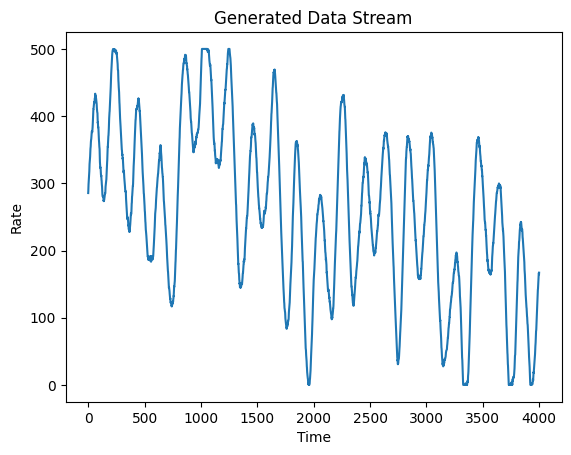

In [3]:
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Rate')
plt.title('Generated Data Stream')
plt.show()

### Data Preprocessing

The training data is normalised between the values 0 and 1.

Note: Ensuring a high number of trends in the training data also meant that all possible 'rates' (data values) were generated in the range 0-500. This is important to make sure the data is normalised relative to the range 0-500.

i.e. If training data was only in the range 100-400, the scaler would be skewed 

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))
data_scaled

array([[0.57104087],
       [0.57657799],
       [0.59144852],
       ...,
       [0.33358793],
       [0.32900278],
       [0.33394986]])

Save the scaler to use for live algorithm

In [5]:
joblib.dump(scaler, 'scaler4.pkl')

['scaler4.pkl']

#### Sliding Window
The sliding window function receives the data and the predefined window length, then creates a 3D array of sliding inputs and a 2D array of expected outputs

FYI: Window length: 100

In [6]:
def create_windows(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [7]:
X, y = create_windows(data_scaled, window_length)
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (3900, 100, 1)
y shape: (3900, 1)


#### Process Data for Pytorch
Converts sliding window inputs and outputs to PyTorch tensors (float type)

A tensor dataset is then created and the data loader is setup with 'shuffle=True' to ensure a robust model

In [8]:
X_train = torch.tensor(X, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

#### Define Model

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, num_layers=1, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        lstm_out1, _ = self.lstm1(x)
        lstm_out2, _ = self.lstm2(lstm_out1)
        out = self.fc(lstm_out2[:, -1, :])
        return out


#### Initialise Model, Loss Function and Optimizer

In [10]:
model = LSTMModel(input_size=1, hidden_size1=50, hidden_size2=25, output_size=1)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

c:\Users\killi\anaconda3\envs\AD_SL\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


#### Training Loop

In [11]:
epoch_list = []
loss_list = []

epochs = 8
for epoch in range(epochs):
    for X_batch, y_batch in train_loader:
        output = model(X_batch)
        loss = loss_function(output, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    epoch_list.append(epoch + 1)
    loss_list.append(loss.item())

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')


    for i in range(min(5, len(y_batch))):
        print(f"Real: {y_batch[i].item()}, Predicted: {output[i].item()}")

Epoch 1/8, Loss: 0.009384457021951675
Real: 0.8221623301506042, Predicted: 0.6939981579780579
Real: 0.525580644607544, Predicted: 0.4926043748855591
Real: 0.4783826172351837, Predicted: 0.40283459424972534
Real: 0.7369247078895569, Predicted: 0.6620792150497437
Real: 0.42984339594841003, Predicted: 0.41830015182495117
Epoch 2/8, Loss: 0.00188576674554497
Real: 0.07923415303230286, Predicted: 0.09076717495918274
Real: 0.7393808960914612, Predicted: 0.7051596641540527
Real: 0.49504896998405457, Predicted: 0.436051607131958
Real: 0.5611918568611145, Predicted: 0.5022799968719482
Real: 0.7848936915397644, Predicted: 0.8367714285850525
Epoch 3/8, Loss: 0.0008254296844825149
Real: 0.805035412311554, Predicted: 0.8019840717315674
Real: 0.15545907616615295, Predicted: 0.1773327887058258
Real: 0.39880552887916565, Predicted: 0.3577114939689636
Real: 0.5155429840087891, Predicted: 0.5232794284820557
Real: 0.3603946268558502, Predicted: 0.3764304518699646
Epoch 4/8, Loss: 0.0002373918832745403
Re

The graph below shows that the model has converged

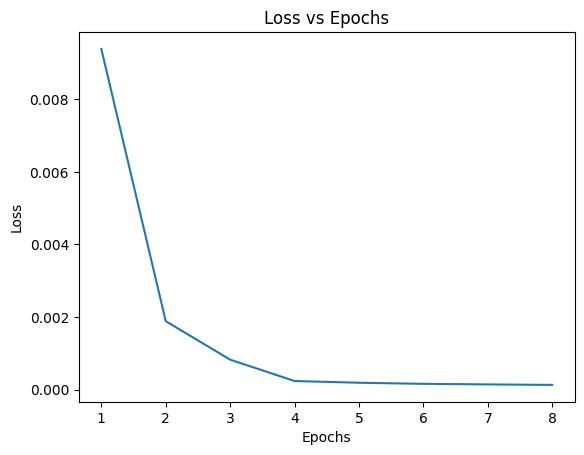

In [12]:
plt.plot(epoch_list, loss_list)
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [13]:
torch.save(model.state_dict(), 'Algorithm4.pth')